In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí AR modelu

Cílem cvičení je namodelovat "covidovou" časovou řadu. Použita bude *datová sada obsahující počty potvrzených případů za posledních 7 a 14 dní za celou ČR včetně přepočtu na 100 000 obyvatel.*
- Link na data: https://onemocneni-aktualne.mzcr.cz/api/v3/docs

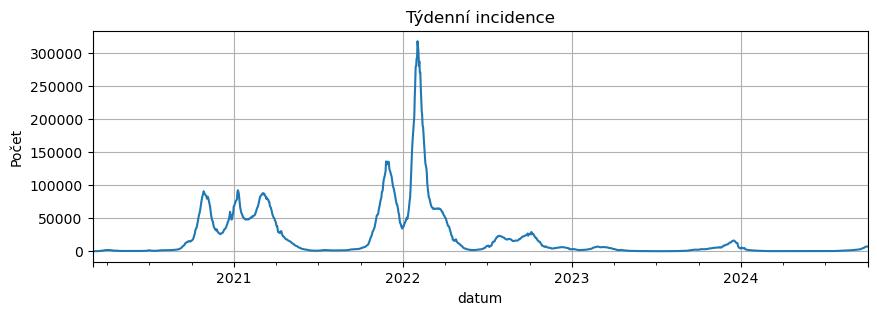

In [2]:
fn = 'incidence-7-14.csv'
data_covid = pd.read_csv(fn, index_col='datum', parse_dates=True)
data_covid = data_covid.asfreq('D')
data_covid['incidence_7'].plot(figsize=(10,3))
plt.title('Týdenní incidence')
plt.ylabel('Počet')
plt.show()

Vybereme si nějakou relativně stabilní situaci, kdy nedochází k rapidní změně trendu. Touto problematikou se budeme totiž zabývat až v příštích týdnech.

Z hlediska pružnosti práce s daty není špatný nápad si datumy držet jako `datetime` instanci.

In [3]:
from datetime import date, timedelta
date_from = '2021-08-01'
date_to = '2021-08-28'
# date_from = '2024-05-01'
# date_to = '2024-05-25'
date_from = date.fromisoformat(date_from)
date_to = date.fromisoformat(date_to)

Nyní se podívejme, jak data vypadají:

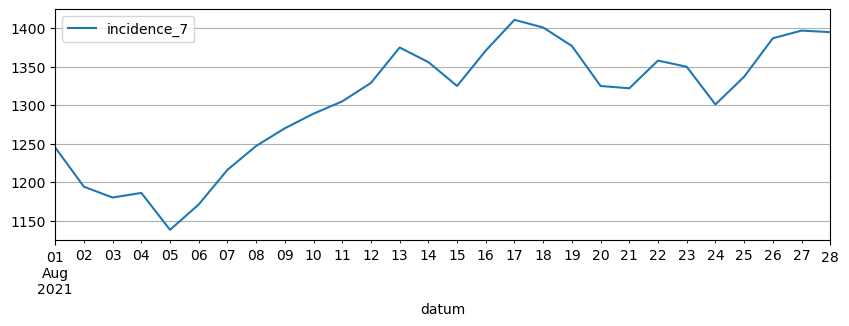

In [4]:
df_orig = data_covid['incidence_7']
df = df_orig.loc[date_from:date_to]
df.plot(figsize=(10,3))
plt.legend()
plt.show()

Zajímat nás bude, jak vypadají ACF a PACF grafy, zdali budou odpovídat alespoň přibližně nějakému AR procesu:

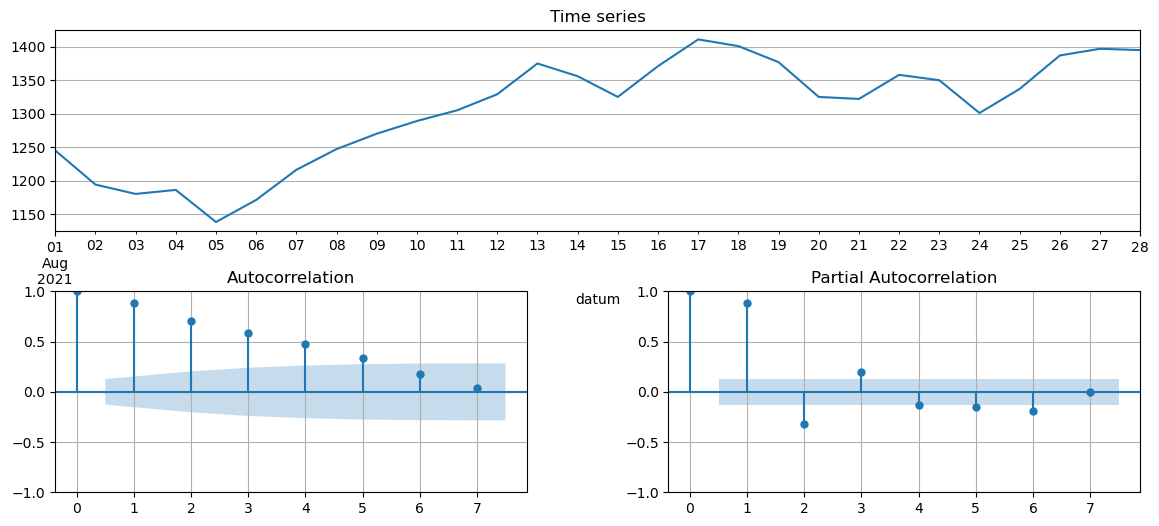

In [5]:
tsplot(df, lags=7)

Zřejmě bychom mohli AR model aspoň zkusit. Budeme se tedy pokoušet o model známý z přednášky ve tvaru

$$
X_t = c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t, \qquad \text{iid.}\ \varepsilon_t \sim \mathrm{N}(0, \sigma^2),
$$

kde $X_t$ reprezentuje modelovanou veličinu, $c$ je offset (posunutí, aditivní konstanta) a $\phi_1, \ldots, \phi_p$ jsou regresní koeficienty.

Podle PACF bychom zkoušeli nejspíš do 2. řádu, podívejme se ještě na automatické hledání řádů pomocí kritérií. Nejčastěji používáme AIC nebo BIC, jejichž hodnotu *minimalizujeme*:

**AIC - [Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion)**

Označme počet odhadovaných parametrů $k$ a maximální hodnotu věrohodnosti při daném modelu $\mathcal{L}$. Potom kritérium je číslo

$$
\mathrm{AIC} = 2k - 2\ln \mathcal{L}.
$$

Kritérium je asymptoticky ekvivalentní ke křížové validaci.

**BIC - [Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion)**

Označme navíc počet pozorování $n$. Potom kritériem je číslo

$$
\mathrm{BIC} = k \ln(n) - 2\ln \mathcal{L}.
$$

V zásadě je jedno, ke kterému se přikloníme, obě mají své výhody a nevýhody, viz články na příslušných odkazech. Ať už vybíráme podle informačního kritéria nebo jinak, v každém případě platí, že **při srovnatelné kvalitě preferujeme modely jednodušší před komplexnějšími**.

In [6]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
out = ar_select_order(df, maxlag=10, ic='bic', trend='c')
print(f'Vhodné řády: {out.ar_lags}')

Vhodné řády: [1, 2, 3]


Pojďme nyní modely nafitovat pomocí `statsmodels`:

In [7]:
model_ar1 = AutoReg(df, lags=1, trend='c')
res_ar1 = model_ar1.fit()
print(res_ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   28
Model:                     AutoReg(1)   Log Likelihood                -131.784
Method:               Conditional MLE   S.D. of innovations             31.880
Date:                Tue, 01 Oct 2024   AIC                            269.569
Time:                        14:02:36   BIC                            273.456
Sample:                    08-02-2021   HQIC                           270.725
                         - 08-28-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            100.0057    102.597      0.975      0.330    -101.080     301.091
incidence_7.L1     0.9275      0.079     11.794      0.000       0.773       1.082
                                    

**V tabulce můžeme vyčíst:**
- logaritmus likelihoodu (čím větší, tím lepší)
- směrodatnou odchylku chyb (čím menší, tím lepší)
- AIC, BIC, HQIC - menší hodnota značí lepší model
- hodnoty odhadnutých koeficientů, jejich standardní chybu, hodnotu testové statistiky (`z`), p-hodnotu testu hypotézy o nulovosti koeficientu (zajímá nás zejm. nejvyšší koeficient) a interval spolehlivosti (zahrnuje 0?)
- kořeny char. rovnice (jsou vně jednotkové kružnice, tj. je modulus > 1?)

Zkusíme ještě další dva řády a podiskutujeme (na cvičení) o rozdílech mezi modely. Který je lepší a proč.

In [8]:
model_ar2 = AutoReg(df, lags=2, trend='c')
res_ar2 = model_ar2.fit()
print(res_ar2.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   28
Model:                     AutoReg(2)   Log Likelihood                -124.358
Method:               Conditional MLE   S.D. of innovations             28.906
Date:                Tue, 01 Oct 2024   AIC                            256.715
Time:                        14:02:36   BIC                            261.747
Sample:                    08-03-2021   HQIC                           258.164
                         - 08-28-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            166.2889     97.072      1.713      0.087     -23.968     356.546
incidence_7.L1     1.1387      0.175      6.526      0.000       0.797       1.481
incidence_7.L2    -0.2614      0.178

In [9]:
model_ar3 = AutoReg(df, lags=3, trend='c')
res_ar3 = model_ar3.fit()
print(res_ar3.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   28
Model:                     AutoReg(3)   Log Likelihood                -118.238
Method:               Conditional MLE   S.D. of innovations             27.401
Date:                Tue, 01 Oct 2024   AIC                            246.477
Time:                        14:02:36   BIC                            252.571
Sample:                    08-04-2021   HQIC                           248.167
                         - 08-28-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            128.7381     99.402      1.295      0.195     -66.086     323.562
incidence_7.L1     1.1756      0.186      6.324      0.000       0.811       1.540
incidence_7.L2    -0.5839      0.269

Trochu předběhneme v přednáškách. Pohledem na koeficienty zjistíme, že p-hodnota `incidence_7.L3` (neboli $\phi_3$) nás vede k *nezamítnutí* hypotézy $H_0: \phi_3 = 0$ na standardní hladině významnosti. Koeficient není statisticky významně odlišný od nuly a v modelu bychom tento řád měli vynechat (tj. preferovat model o řád nižší).

Vybereme si tedy zřejmě AR(2). Jak si stojí z hlediska reziduí?

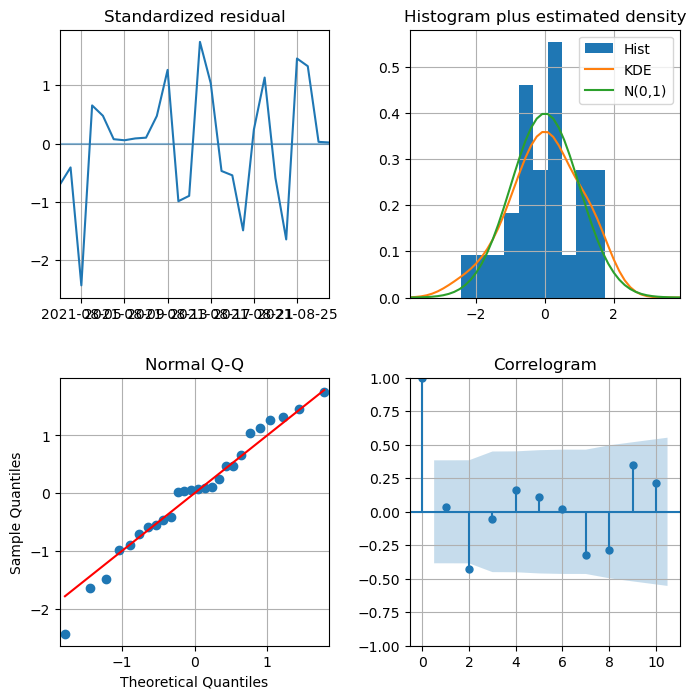

In [10]:
res_ar2.plot_diagnostics(figsize=(8,8))
plt.show()

Grafy nám říkají:
- jaký je průběh reziduí (= časová řada hodnot reziduí) - vidíme nějaké outliery, "systematičnost" apod.?
- histogram a jádrový odhad hustoty (KDE) reziduí - přípomíná KDE přikreslenou "gaussovku"?
- Q-Q plot - leží kvantily reziduí (tečky) na přímce, která by odpovídala kvantilům "gaussovky"?
- korelogram - jsou rezidua vzájemně nekorelovaná?

**Predikce:**

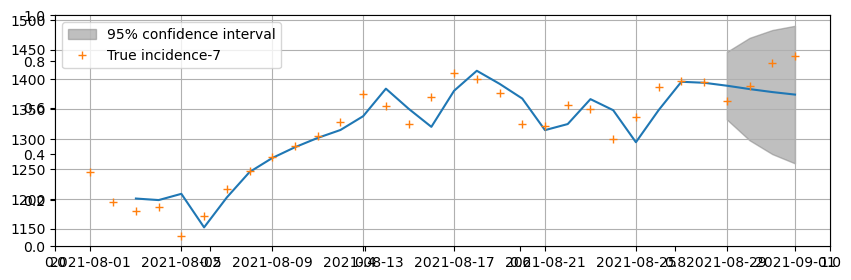

In [11]:
fcast_horizon = 4
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
res_ar2.plot_predict(0, date_to + timedelta(days=fcast_horizon), fig=fig, alpha=0.05)
plt.plot(df_orig.loc[date_from:date_to + timedelta(days=fcast_horizon)],
         '+', label='True incidence-7')
plt.legend()
plt.show()

Proč nemáme predikce pro první dvě měření incidence?

In [12]:
res_ar2.predict(0, date_to + timedelta(days=fcast_horizon))

2021-08-01            NaN
2021-08-02            NaN
2021-08-03    1200.433464
2021-08-04    1197.824878
2021-08-05    1208.317453
2021-08-06    1152.089841
2021-08-07    1202.217149
2021-08-08    1244.832288
2021-08-09    1268.367913
2021-08-10    1286.453919
2021-08-11    1302.076558
2021-08-12    1315.328786
2021-08-13    1338.475170
2021-08-14    1384.582027
2021-08-15    1350.919800
2021-08-16    1320.586649
2021-08-17    1381.072887
2021-08-18    1414.595623
2021-08-19    1392.750609
2021-08-20    1368.035566
2021-08-21    1315.096340
2021-08-22    1325.275207
2021-08-23    1367.053751
2021-08-24    1348.531967
2021-08-25    1294.825833
2021-08-26    1348.630768
2021-08-27    1396.155218
2021-08-28    1394.470336
2021-08-29    1389.578446
2021-08-30    1383.927657
2021-08-31    1378.910373
2021-09-01    1374.674411
Freq: D, dtype: float64